In [ ]:
from notebooks import *
print_sys_info()

platform:
  machine: x86_64
  node: 9b938c14577d
  processor: x86_64
  release: 4.14.33+
  system: Linux
  version: '#1 SMP Wed Jun 20 01:15:52 PDT 2018'
cpu: 16
mem: 102g
swap: 0g


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[22:02:25.348] DEBUG  Projection.load
  path: /app/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (recs/sp)' % (desc, '%s/%s' % (len(df), df.species.nunique()))))
countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[35k/334 -> 25k/127 -> 21k/100 ->  10k/100 ->  10k/100]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[35k/334 -> 32k/224 -> 16k/100 -> 9.0k/100 -> 9.0k/100]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[35k/334 -> 35k/334 -> 12k/100 -> 6.8k/100 -> 6.8k/ 99]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[34k/334 -> 34k/334 -> 18k/168 ->  11k/168 ->  11k/167]  # compare.ipynb all
# recs_at_least, num_species, num_recs =   0, 168,  20  # ca[34k/334 -> 35k/334 -> 18k/168 ->  3.2/168 ->  3.2/167]  # compare.ipynb recs
recs_at_least, num_species, num_recs =  20, 168,  20  # ca[35k/334 -> 35k/296 -> 20k/168 ->  3.4/168 ->  3.4/168]  # compare.ipynb recs
# recs_at_least, num_species, num_recs =   0, 50,  100  # Faster dev
# recs_at_least, num_species, num_recs =   0, 50,  20   # Faster dev
# recs_at_least, num_species, num_recs =   0, 50,  5    # Faster dev
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
display(
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              399859/9442 (recs/sp)
countries         59713/1148 (recs/sp)
com_names          35236/334 (recs/sp)
(downloaded)       35228/334 (recs/sp)
recs_at_least      34842/296 (recs/sp)
num_species        19638/168 (recs/sp)


num_recs            3360/168 (recs/sp)
recs ≥ 2            3360/168 (recs/sp)


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,94080,3360,3360,1,NaN,NaN,True,True,True,True,True
species,category,178080,3360,3360,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
id,int64,94080,3360,3360,3360,213310.169,108044.426,1133,138144,193659,308285,416744
sci_name,category,227200,3360,3360,168,NaN,NaN,Anser albifrons,Gelochelidon nilotica,Vireo olivaceus,Parkesia noveboracensis,Spinus tristis
com_name,category,220320,3360,3360,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
subspecies,object,169597,3360,3360,206,NaN,NaN,,,,,zaboria
recordist,object,211704,3360,3360,291,NaN,NaN,AJ Knue,Frank Lambert,Matthias Feuersenger,Peter Boesman,tetiaroa
country,object,203070,3360,3360,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,316498,3360,3360,1741,NaN,NaN,"Bahía la Ventosa, Salina Cruz, Oaxaca","Deseret Land and Livestock Ranch, Rich County, Utah","May Lake, Yosemite NP, California","Sabal Palm Sanctuary, Cameron, Texas","west of Thorp, WA"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
COGA,205189,True,COGA,207451,Gallinula galeata,Common Gallinule,sandvicensis,Ross Gallardy,United States,"Kailua, Honolulu County, Hawaii",21.4,-158.0,call,B,2014-12-21 00:00:00,07:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/207451,//www.xeno-canto.org/207451/download
INDO,18832,True,INDO,398616,Columbina inca,Inca Dove,,Manuel Grosselet,Mexico,Lomas de Bezares Miguel Hidalgo Mexico city,19.4,-99.2,song,B,2018-01-07 00:00:00,08:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/398616,//www.xeno-canto.org/398616/download
EWPW,223194,True,EWPW,188611,Antrostomus vociferus,Eastern Whip-poor-will,,David Jonas Weber,United States,"Gravelly Hill Rd., Salem County, New Jersey",39.5,-75.4,song,C,2014-07-25 00:00:00,05:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/188611,//www.xeno-canto.org/188611/download
NUWO,113835,True,NUWO,301366,Picoides nuttallii,Nuttall's Woodpecker,,Denise Wight,United States,"Moraga, Contra Costa County, California",37.8,-122.0,"Hawk mobbing call, alarm call",C,2016-01-25 00:00:00,10:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/301366,//www.xeno-canto.org/301366/download
BBWO,80808,True,BBWO,335436,Picoides arcticus,Black-backed Woodpecker,,Lance A. M. Benner,United States,"Blackrock Trailhead, Tulare County, California",36.2,-118.0,"drumming, male",no score,2016-09-17 00:00:00,16:41,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/335436,//www.xeno-canto.org/335436/download
HUVI,117936,True,HUVI,297126,Vireo huttoni,Hutton's Vireo,,Paul Marvin,United States,"Kickapoo Cavern State Park, Brackettville, Texas",29.6,-100.0,song,C,2012-04-08 00:00:00,07:58,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/297126,//www.xeno-canto.org/297126/download
MGWA,89731,True,MGWA,326299,Geothlypis tolmiei,MacGillivray's Warbler,,Lance A. M. Benner,United States,"Buckhorn Campground, San Gabriel Mountains, Los Angeles County, California",34.3,-118.0,"male, song",no score,2016-06-28 00:00:00,10:49,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/326299,//www.xeno-canto.org/326299/download
PUFI,159786,True,PUFI,254326,Haemorhous purpureus,Purple Finch,,Iain,Canada,"Algonquin Highlands, Haliburton County, Ontario",45.3,-78.8,song,C,2015-06-27 00:00:00,11:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/254326,//www.xeno-canto.org/254326/download
CAFI,46804,True,CAFI,369971,Haemorhous cassinii,Cassin's Finch,,Eric DeFonso,United States,"Dunton Rd area, San Juan National Forest, Dolores County, Colorado",37.8,-108.0,song,A,2016-06-28 00:00:00,15:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/369971,//www.xeno-canto.org/369971/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    len(xcs_paths),
    # xcs_paths[:2],
)

3360

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,171156,3356,3356,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,177868,3356,3356,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
species_com_name,category,218906,3356,3356,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
species_query,object,177868,3356,3356,168,NaN,NaN,ACWO,CONI,LBCU,RNGR,YRWA
duration_s,float64,80544,3356,3356,3052,5.424e+01,7.032e+01,0.697,14.4,31.8,65,940
samples_mb,float64,80544,3356,3356,3053,2.295e+00,2.973e+00,0.0293,0.607,1.34,2.76,39.5
samples_n,int64,93968,3356,3356,3053,1.203e+06,1.559e+06,15368,318275,702144,1444716,20731931
basename,object,181224,3356,3356,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,242398,3356,3356,168,NaN,NaN,Greater White-fronted Goose - GWFG,Gull-billed Tern - GBTE,Red-eyed Vireo - REVI,Northern Waterthrush - NOWA,American Goldfinch - AMGO


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,GWFG,Greater White-fronted Goose,GWFG,23.7,0.997,522850,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/149379/audio,xc/data/GWFG/149379/audio.mp3
1,xc,GWFG,Greater White-fronted Goose,GWFG,18.3,0.770,403780,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276918/audio,xc/data/GWFG/276918/audio.mp3
2,xc,GWFG,Greater White-fronted Goose,GWFG,45.0,1.890,991296,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/210100/audio,xc/data/GWFG/210100/audio.mp3
3,xc,GWFG,Greater White-fronted Goose,GWFG,17.6,0.738,387072,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/323113/audio,xc/data/GWFG/323113/audio.mp3
4,xc,GWFG,Greater White-fronted Goose,GWFG,24.0,1.010,528142,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276919/audio,xc/data/GWFG/276919/audio.mp3


In [ ]:
# Fast-and-cheap version (<1s) of the plot below (7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

,species_longhand,num_recs
0,Greater White-fronted Goose - GWFG,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
1,Gadwall - GADW,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
2,American Wigeon - AMWI,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
3,Mallard - MALL,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
4,Green-winged Teal - GWTE,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
5,California Quail - CAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
6,Gambel's Quail - GAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
7,Sooty Grouse - SOGR,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
8,Wild Turkey - WITU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
9,Common Loon - COLO,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20


In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
recs = projection.transform(recs)

In [ ]:
# GridSearchCV many models / model params
param_grid = dict(
    classifier=[

        # RandomForest(entropy)
        #   - [SP14] uses entropy
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 10',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200',  # [SP14]
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 800',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 1000',

        # RandomForest(gini)
        #   - sk uses gini by default

        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1',  # Faster dev
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 10',  # [sk default]
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 50',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 100',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 200',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 400',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 600',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 800',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1000',

        # WARNING These two are not very mem safe...
        #   - They finish, but they cause OSX to "Not responding" most/all of its apps at ~2-3 different times
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 1500',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 2000',

    ],
    # Subset for learning curves
    # subset_per_class=[
    #     1., .75, .5, .25,  # Biggest first, to fail fast
    #     # 1., .5,  # Faster dev
    #     # 1., .1,  # Faster dev
    # ],
)

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        # n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        # n_splits=3,
        # n_splits=5,
        n_splits=8,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        test_i='i_test',
        test_y='y_test',
        test_classes='estimator.classes_',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
    ),
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # n_jobs=1,  # For %prun
    # n_jobs=6,  # Doesn't peg all 8 hyperthreads
    # n_jobs=8,
    n_jobs=16,  # Not mem safe on laptop (16x rf classifiers)
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 8 folds for each of 2 candidates, totalling 16 fits


[22:02:33.806] INFO   _fit_and_score... split_i[0], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:02:33.847] INFO   _fit_and_score... split_i[1], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:02:33.885] INFO   _fit_and_score... split_i[2], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:02:33.924] INFO   _fit_and_score... split_i[3], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:02:33.969] INFO   _fit_and_score... split_i[4], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:02:34.006] INFO   _fit_and_score... split_i[5], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:02:34.051] INFO   _fit_and_score... split_i[6], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:02:34.090] INFO   _fit_and_score... split_i[7], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:02:34.129] INFO   _fit_and_score... split_i[0], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:02:34.170] INFO   _fit_and_score... split_i[1], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:02:34.214] INFO   _fit_and_score... split_i[2], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:02:34.257] INFO   _fit_and_score... split_i[3], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:02:34.291] INFO   _fit_and_score... split_i[4], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:02:34.335] INFO   _fit_and_score... split_i[5], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:02:34.375] INFO   _fit_and_score... split_i[6], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:02:34.404] INFO   _fit_and_score... split_i[7], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:35:47.147] INFO   _fit_and_score[1993.138s]: split_i[5], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:35:48.020] INFO   _fit_and_score[1994.093s]: split_i[3], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed: 33.3min remaining: 232.9min


[22:35:55.927] INFO   _fit_and_score[2001.954s]: split_i[4], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:35:57.809] INFO   _fit_and_score[2003.921s]: split_i[2], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:36:12.721] INFO   _fit_and_score[2018.871s]: split_i[1], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:36:15.105] INFO   _fit_and_score[2021.295s]: split_i[0], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:36:19.288] INFO   _fit_and_score[2025.232s]: split_i[6], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:36:30.946] INFO   _fit_and_score[2036.849s]: split_i[7], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1500', random_state=0)]


[22:43:00.581] INFO   _fit_and_score[2426.234s]: split_i[5], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:43:34.614] INFO   _fit_and_score[2460.479s]: split_i[0], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:43:37.193] INFO   _fit_and_score[2462.971s]: split_i[2], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:43:39.561] INFO   _fit_and_score[2465.294s]: split_i[3], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:43:50.261] INFO   _fit_and_score[2476.083s]: split_i[1], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:43:59.247] INFO   _fit_and_score[2484.947s]: split_i[4], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:44:05.740] INFO   _fit_and_score[2491.320s]: split_i[7], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[22:44:18.923] INFO   _fit_and_score[2504.540s]: split_i[6], train[2684], test[672], classes[168], estimator[Search(downsample_classes=None, downsample_per_class=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 2000', random_state=0)]


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed: 41.8min finished


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, classifier_type, fold, ...
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: {
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_')},
        'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    }))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params
    .assign(
        # Useful for validation curves (vary params by classifier type)
        # classifier_type=lambda df: df.params_dict.str['classifier'].apply(lambda x: (
        #     '%s-%s' % (x['cls'], x['criterion']) if x['cls'] == 'rf' else
        #     x['cls']
        # )),
        # Useful for learning curves (vary subset_classes per classifier)
        classifier_type=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, v) for k, v in d.items() if k not in ['subset_classes']
        )),
    )
    # .eval
    .assign(test_evals=lambda df: np.vectorize(SearchEvals)(
        i=df.pop('test_i'),
        y=df.pop('test_y'),
        classes=df.pop('test_classes'),
        y_scores=df.pop('test_predict_proba'),
    ))
    # Reorder
    .pipe(df_reorder_cols, first=[
        'model_id', 'params', 'params_dict', 'classifier_type',
    ])
)
param_list = list(cv_models.params.unique())
display(
    df_summary(cv_models).T,
    # cv_models[:5],
    cv_models,
    param_list,
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,2096,16,16,16.0,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[3]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[7]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[3]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[7]"
params,object,1952,16,16,2.0,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]"
params_dict,object,3840,16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
classifier_type,object,2176,16,16,2.0,NaN,NaN,"classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]"
fold,int64,440,16,16,8.0,NaN,NaN,0,1,3,5,7
train_score,float64,384,16,16,1.0,NaN,NaN,-1,-1,-1,-1,-1
test_score,float64,384,16,16,2.0,NaN,NaN,-5,-5,-4,-4,-4
fit_time,float64,384,16,16,16.0,NaN,NaN,1.98e+03,1.99e+03,2.03e+03,2.45e+03,2.49e+03
score_time,float64,384,16,16,16.0,NaN,NaN,1.57,1.94,2.1,2.2,2.53


,model_id,params,params_dict,classifier_type,fold,train_score,test_score,fit_time,score_time,test_evals
0,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",0,-1.0,-4.0,2010.0,2.45,"SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])"
1,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",1,-1.0,-4.0,2010.0,1.84,"SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])"
2,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[2]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",2,-1.0,-5.0,1990.0,2.53,"SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])"
3,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[3]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",3,-1.0,-5.0,1980.0,2.20,"SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])"
4,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[4]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",4,-1.0,-5.0,1990.0,2.43,"SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])"
5,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[5]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",5,-1.0,-5.0,1980.0,2.29,"SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])"
6,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[6]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",6,-1.0,-4.0,2020.0,1.67,"SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])"
7,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[7]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",7,-1.0,-4.0,2030.0,1.57,"SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])"
8,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_es

[
    'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: '
        '1500]',
    'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: '
        '2000]'
]

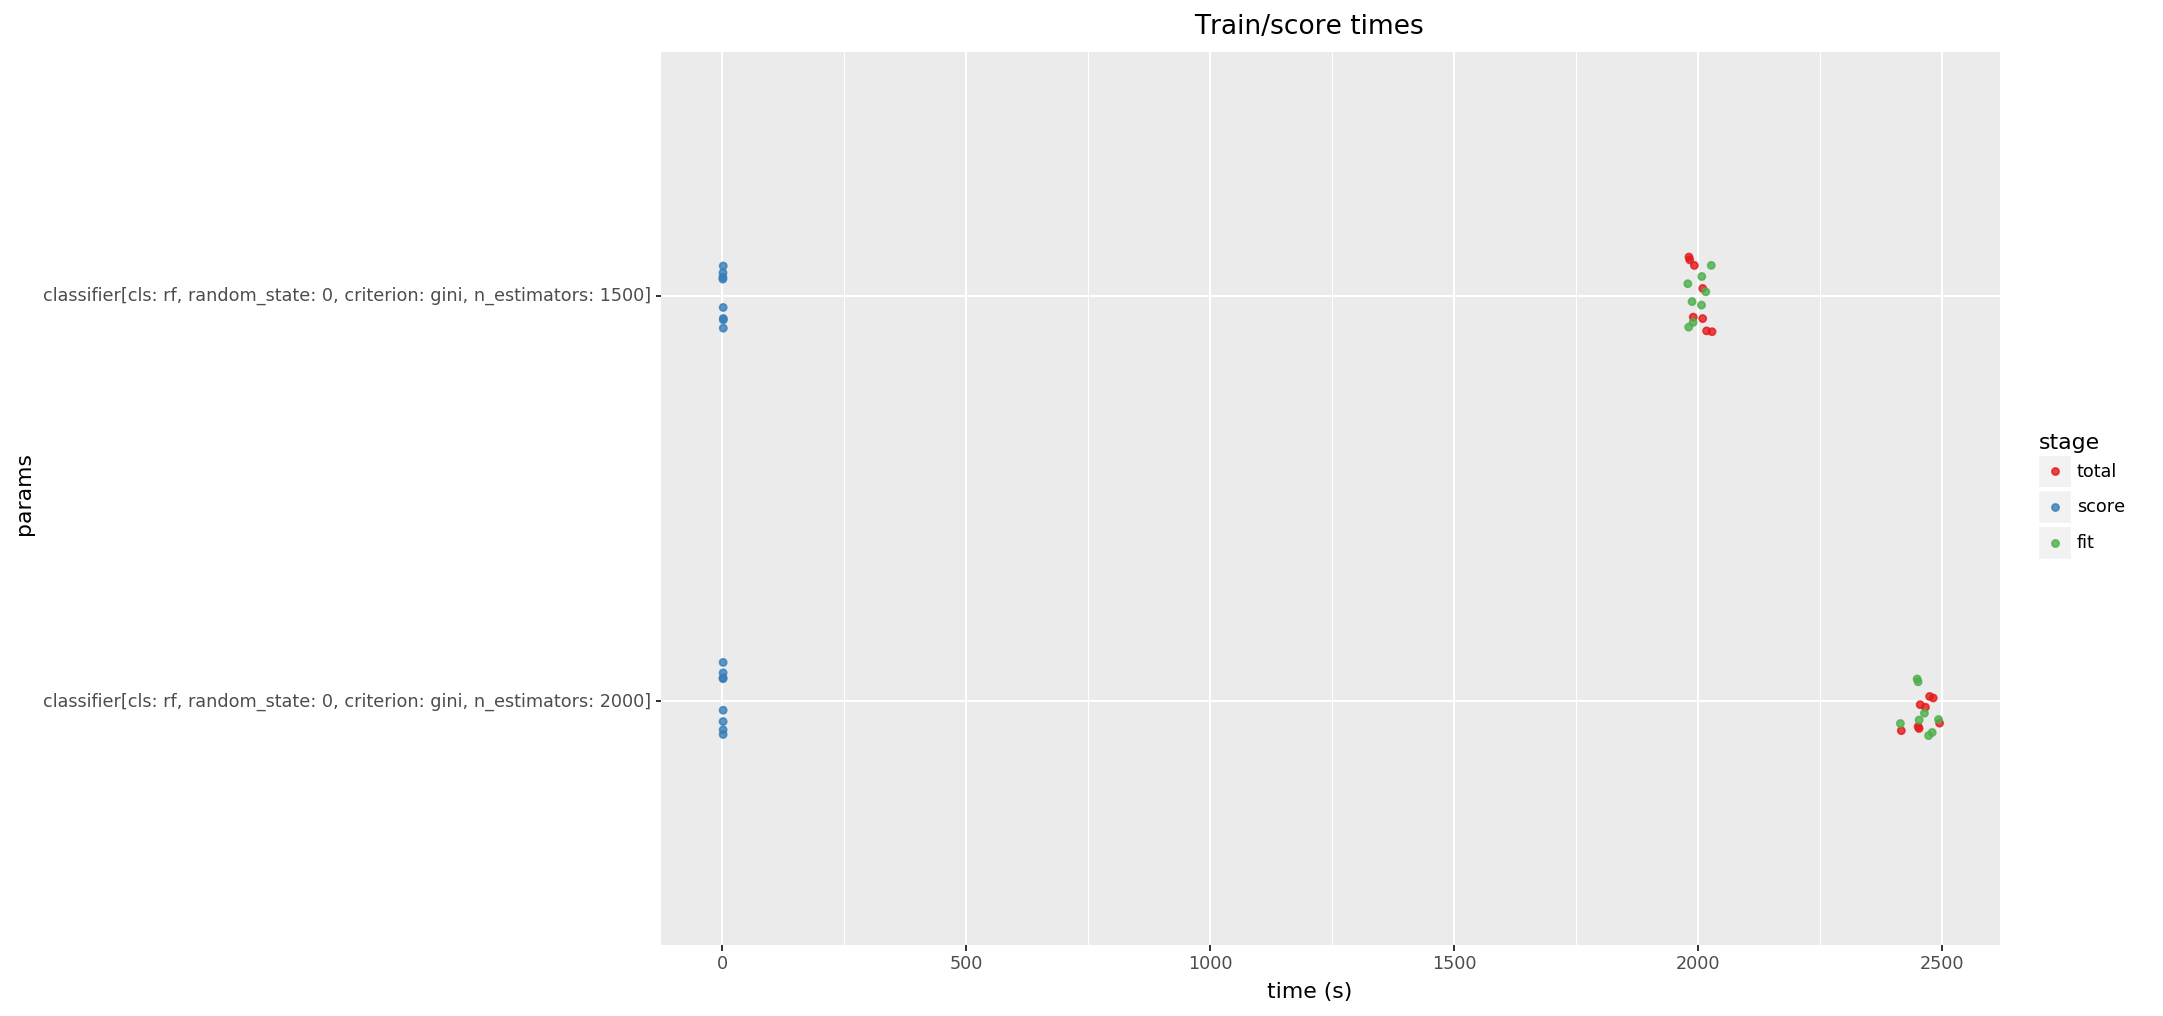

<ggplot: (-9223363254113587168)>

In [ ]:
(cv_models
    .assign(total_time=lambda df: df.fit_time + df.score_time)
    .pipe(lambda df: pd.melt(
        df,
        id_vars=['classifier_type', 'params', 'fold'],
        value_vars=['fit_time', 'score_time', 'total_time'],
        var_name='stage',
        value_name='time',
    ))
    .assign(
        stage=lambda df: df.stage.str.replace('_time', ''),
        group=lambda df: df.classifier_type.str.cat(df.stage, '/'),
    )
    .pipe(df_ordered_cat,
        params=lambda df: reversed(param_list),
        stage=lambda df: reversed(sorted(df.stage.unique())),  # Make stage=total (last by alpha) be red (first color)
    )
    .pipe(ggplot, aes(x='params', y='time', color='stage'))
    + geom_jitter(alpha=.8, width=.1, height=1e-9, random_state=0)
    + coord_flip()
    + expand_limits(y=0)
    + scale_color_cmap_d(mpl.cm.Set1)
    + ylab('time (s)')
    + ggtitle('Train/score times')
)

/opt/conda/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:82: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "


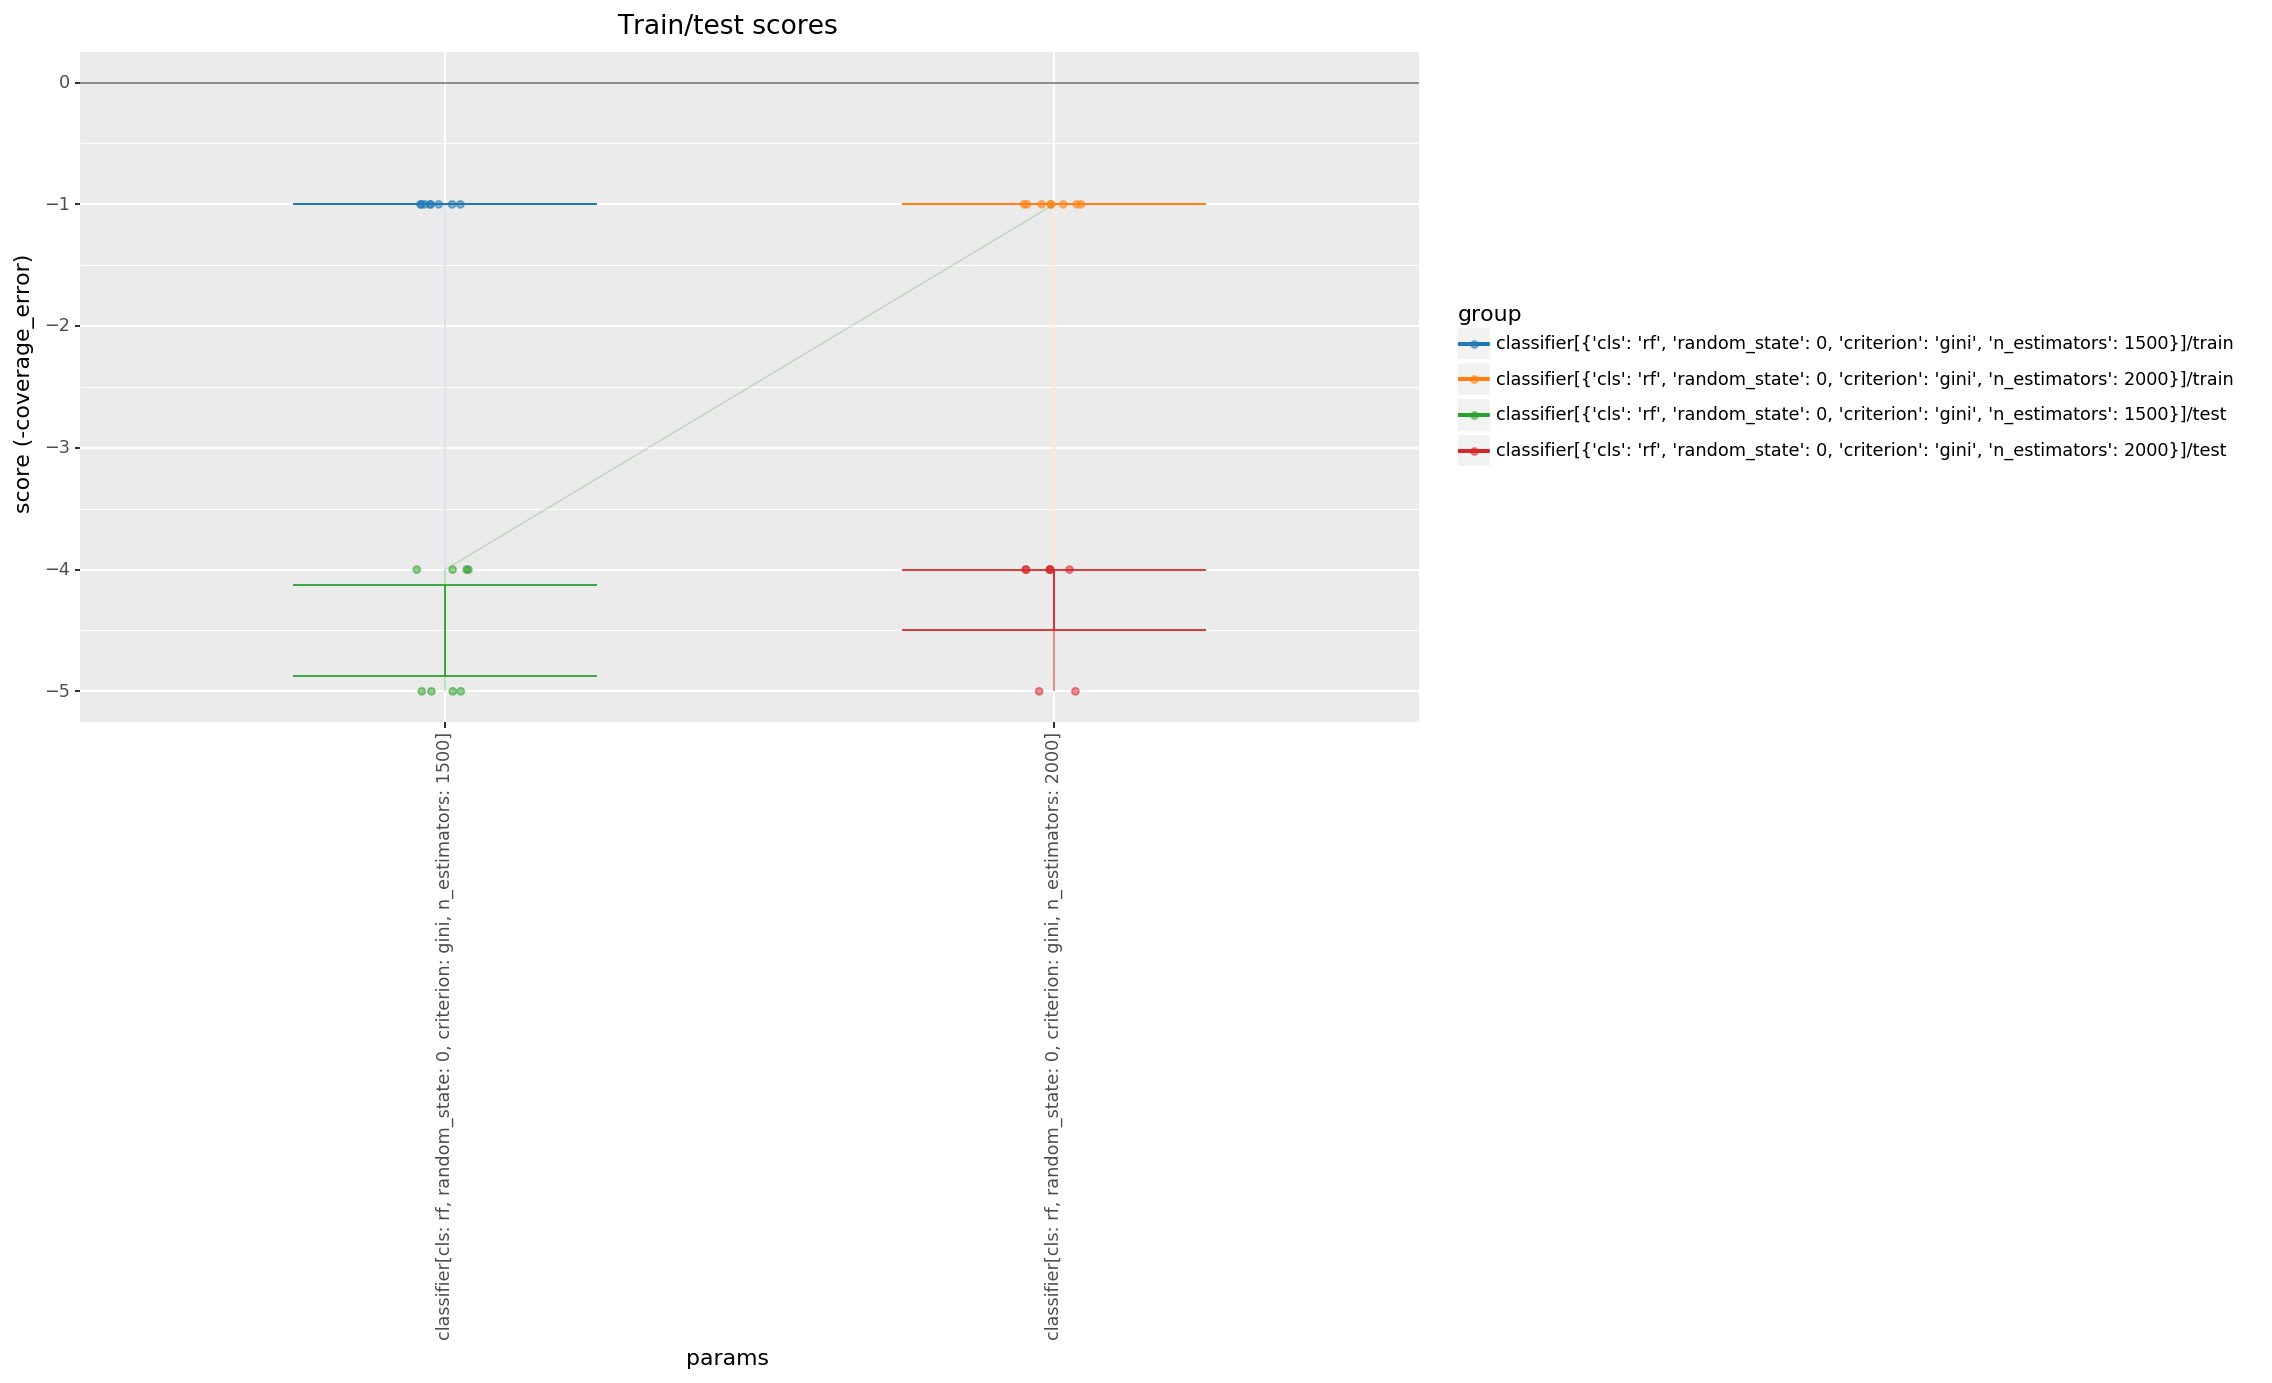

<ggplot: (8782743221880)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(lambda df: pd.melt(
        df,
        id_vars=['classifier_type', 'params', 'fold'],
        value_vars=['train_score', 'test_score'],
        var_name='split',
        value_name='score'),
    )
    .assign(
        split=lambda df: df.split.str.replace('_score', ''),
        group=lambda df: df.classifier_type.str.cat(df.split, '/'),
    )
    .pipe(df_ordered_cat,
        params=lambda df: param_list,
        group=lambda df: df.group.unique(),
    )
    .pipe(ggplot, aes(x='params', y='score', color='group'))
    + geom_hline(yintercept=0, color='grey')
    + geom_jitter(alpha=.5, width=.05, height=1e-9)
    # + geom_point(alpha=.5)
    + geom_line(aes(group='str(group) + str(fold)'), alpha=.2)
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='line', size=1)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(axis_text_x=element_text(angle=90, hjust=.5))
    + theme_figsize(width=12, aspect_ratio=1/2)
    # + coord_cartesian(ylim=(-35, 0))
    + ylab('score (-coverage_error)')
    + ggtitle('Train/test scores')
)

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(param_list))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/2]
  fold[*/8]


In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            classifier_type=row.classifier_type,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
)
display(
    df_summary(coverage_errors_all_all).T,
    coverage_errors_all_all[:10],
)

  0%|                                                                                                        | 0/16 [00:00<?, ?it/s]

  6%|██████                                                                                          | 1/16 [00:00<00:04,  3.53it/s]

 12%|████████████                                                                                    | 2/16 [00:00<00:03,  3.56it/s]

 19%|██████████████████                                                                              | 3/16 [00:00<00:03,  3.52it/s]

 25%|████████████████████████                                                                        | 4/16 [00:01<00:03,  3.27it/s]

 31%|██████████████████████████████                                                                  | 5/16 [00:01<00:03,  3.33it/s]

 38%|████████████████████████████████████                                                            | 6/16 [00:01<00:02,  3.37it/s]

 44%|██████████████████████████████████████████                                                      | 7/16 [00:02<00:02,  3.39it/s]

 50%|████████████████████████████████████████████████                                                | 8/16 [00:02<00:02,  3.40it/s]

 56%|██████████████████████████████████████████████████████                                          | 9/16 [00:02<00:02,  3.41it/s]

 62%|███████████████████████████████████████████████████████████▍                                   | 10/16 [00:02<00:01,  3.40it/s]

 69%|█████████████████████████████████████████████████████████████████▎                             | 11/16 [00:03<00:01,  3.34it/s]

 75%|███████████████████████████████████████████████████████████████████████▎                       | 12/16 [00:03<00:01,  3.29it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▏                 | 13/16 [00:03<00:00,  3.26it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 14/16 [00:04<00:00,  3.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████      | 15/16 [00:04<00:00,  3.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,2524032,10752,10752,16,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[3]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[7]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[3]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[7]"
params,object,2306304,10752,10752,2,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]"
classifier_type,object,2644992,10752,10752,2,NaN,NaN,"classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]"
fold,int64,295680,10752,10752,8,NaN,NaN,0,1,3,5,7
i,int64,301056,10752,10752,2771,NaN,NaN,1,839,1679,2517,3354
y_true,object,913920,10752,10752,168,NaN,NaN,ACWO,CONI,LASP,RIRA,YRWA
coverage_error,float64,258048,10752,10752,163,NaN,NaN,1,1,4,19,168


,model_id,params,classifier_type,fold,i,y_true,coverage_error
0,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",0,1335,HAWO,25.0
1,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",0,1219,BTAH,2.0
2,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",0,1159,MWPW,6.0
3,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",0,3033,WETA,1.0
4,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",0,635,LBDO,48.0
5,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",0,693,BOGU,51.0
6,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",0,2774,CASP,1.0
7,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",0,1801,CLNU,14.0
8,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",0,1343,WHWO,37.0
9,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1500}]",0,1823,CORA,2.0


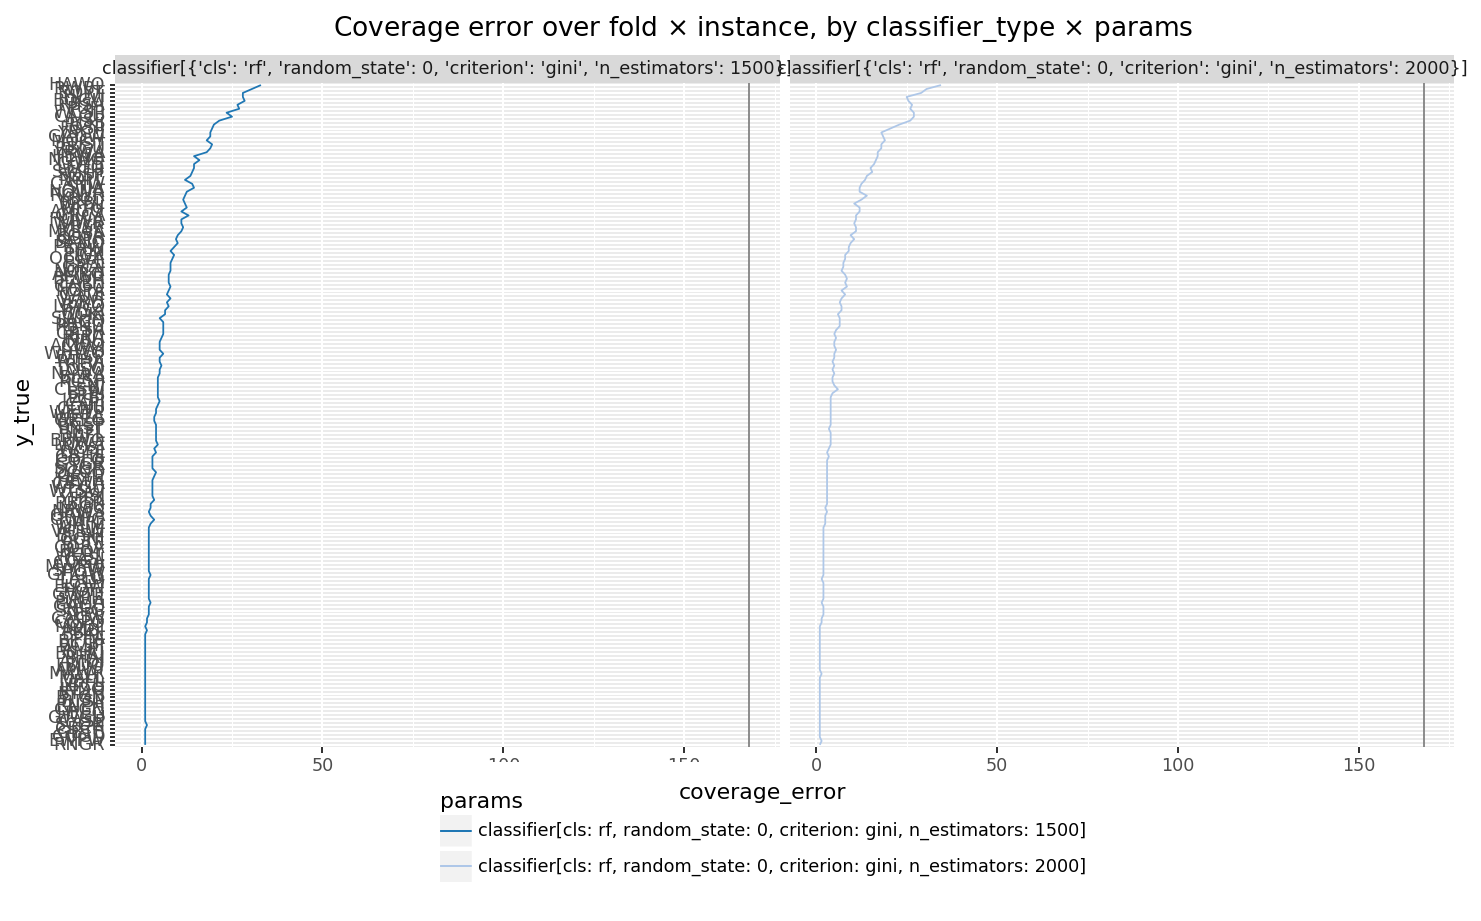

<ggplot: (-9223363254119441881)>

In [ ]:
# Facet by classifier_type, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    .pipe(df_ordered_cat,
        y_true=lambda df: (
            # Sort species by median(coverage_error) (across all models)
            df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
            # Sort species by taxo (hard to compare across models, unless they're pretty low noise)
            # reversed(recs.species.cat.categories)
        ),
        params=lambda df: df.params.unique(),
        classifier_type=lambda df: df.classifier_type.unique(),
    )
    .pipe(ggplot, aes(x='y_true', y='coverage_error', color='params'))
    + facet_wrap('classifier_type')
    + geom_line(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip(
        # ylim=(0, min(30, len(np.unique(y)))),  # TODO Restore after debug
    )
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme(legend_position='bottom', legend_direction='vertical')
    + theme_figsize('square')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold $\times$ instance, by classifier_type $\times$ params')
)

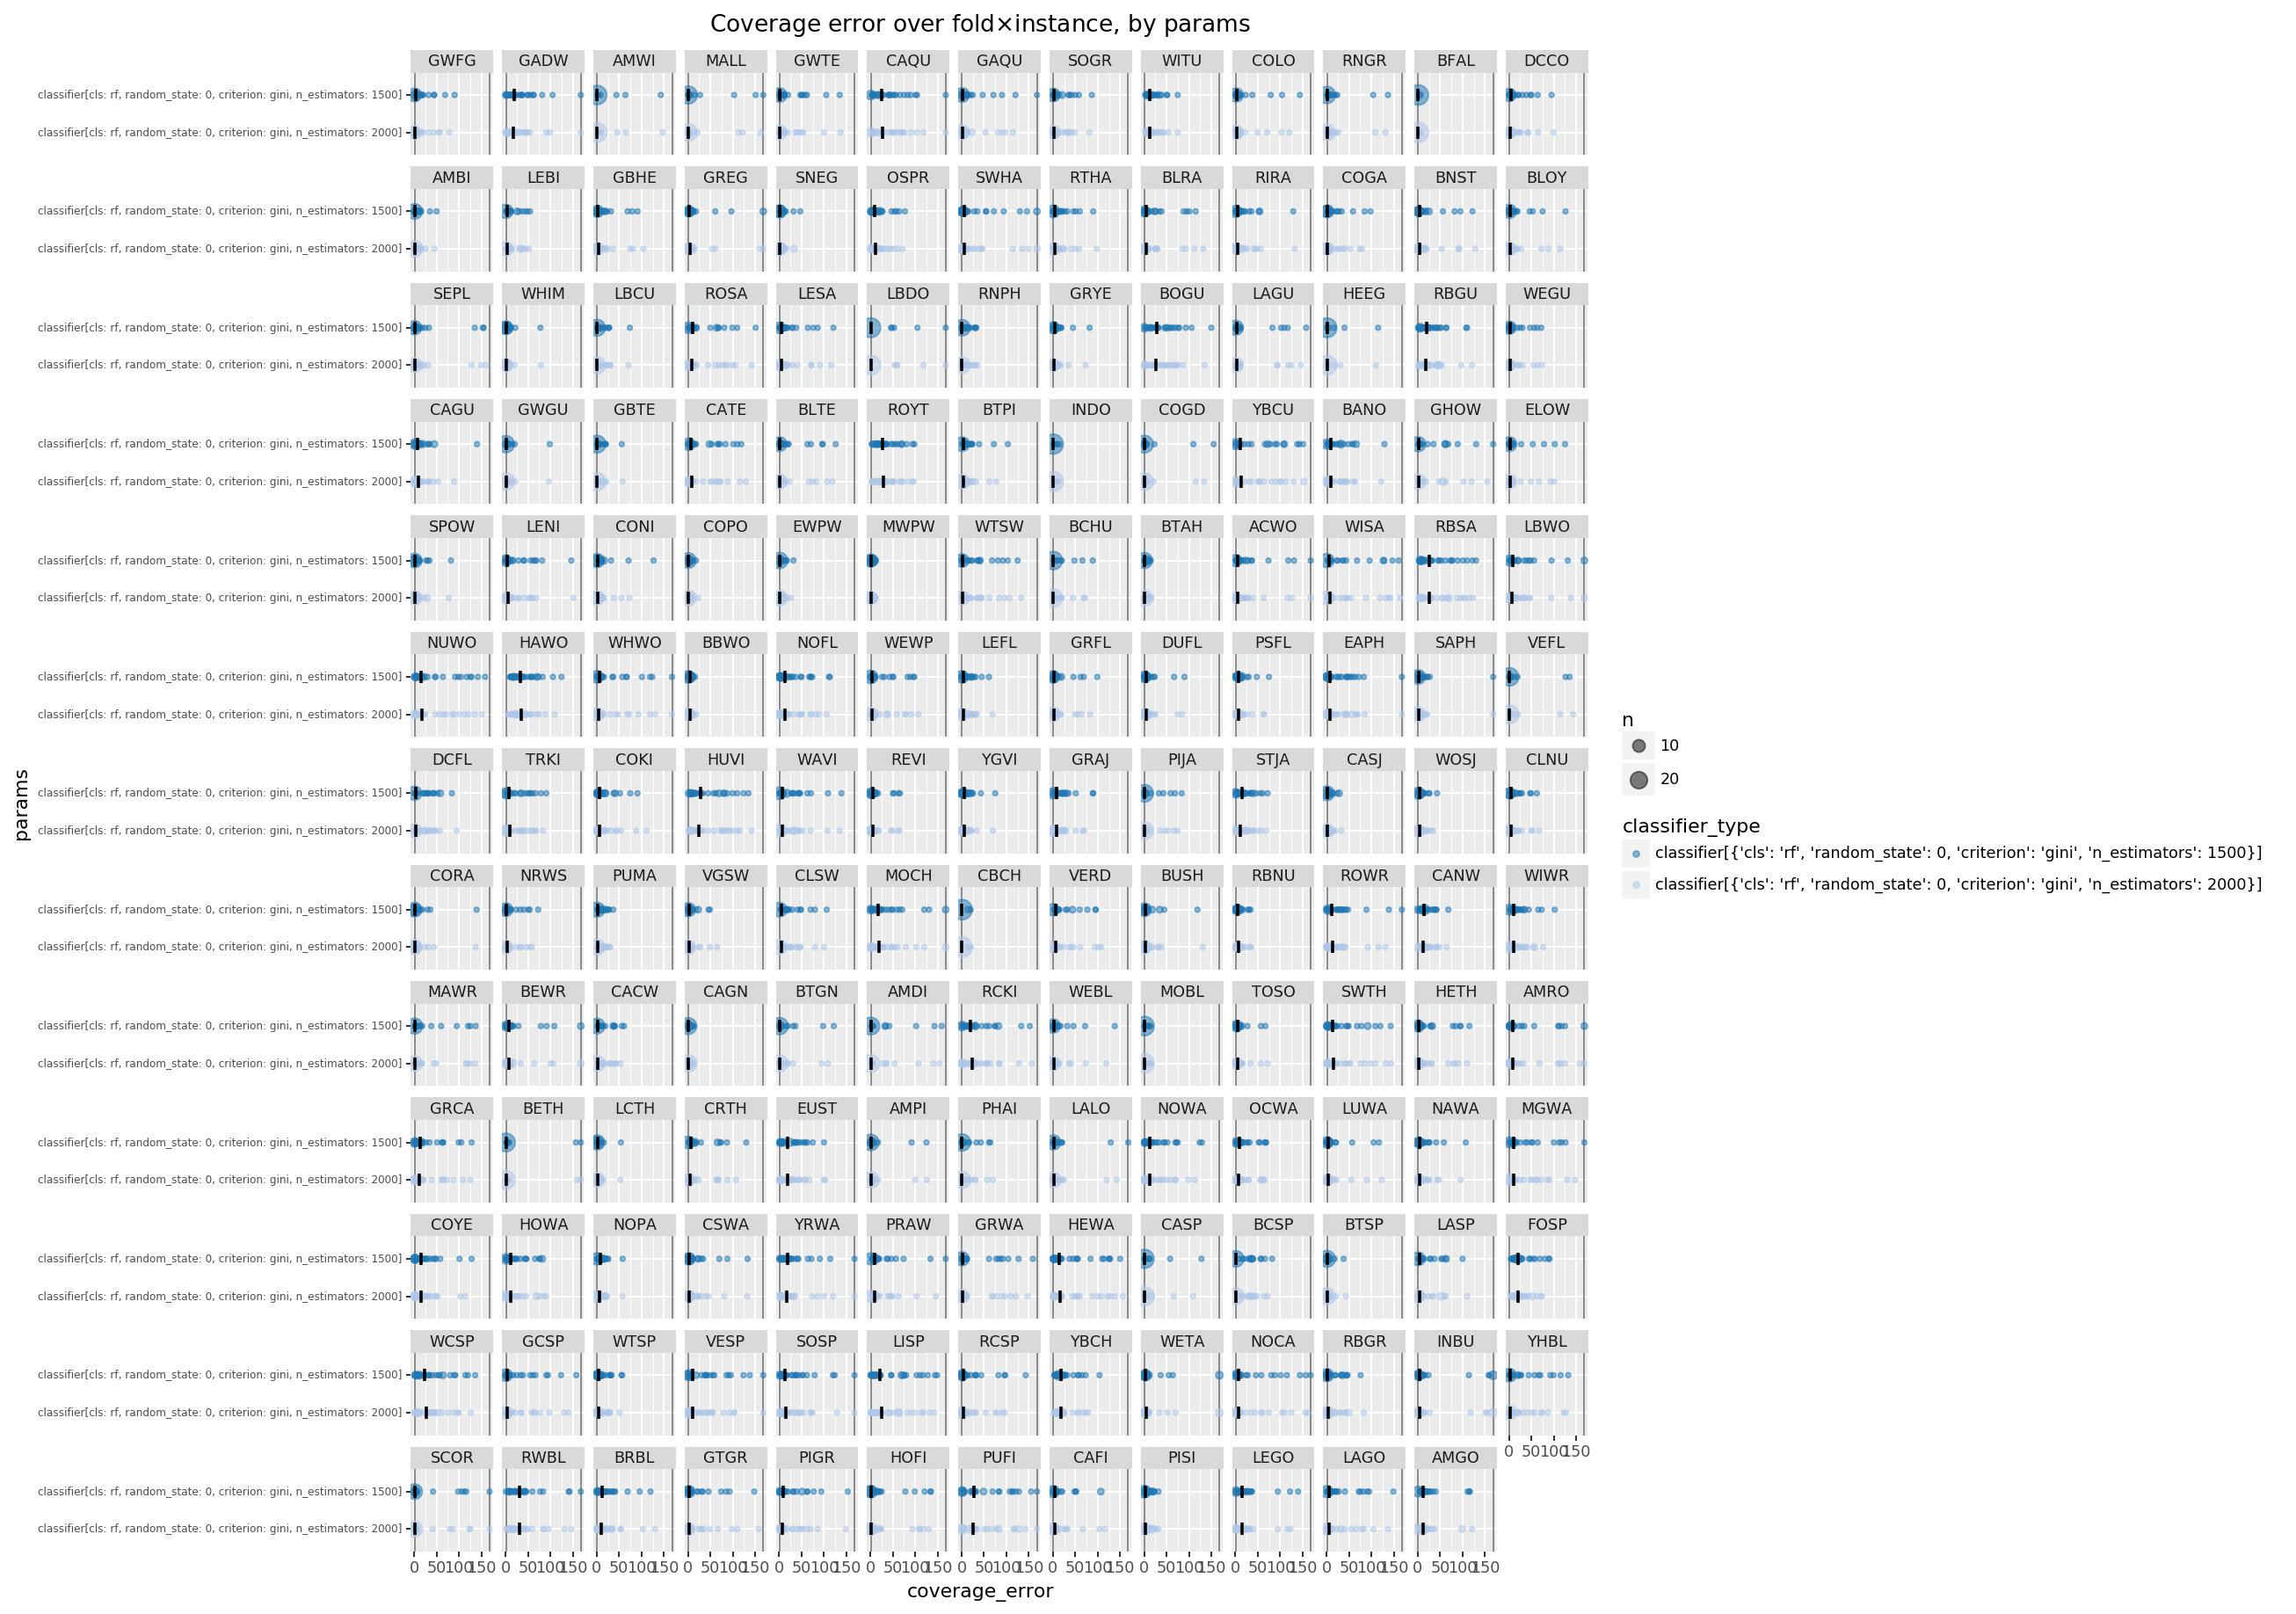

<ggplot: (-9223363254129982015)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # .sample(200, random_state=0)  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_ordered_cat, params=lambda df: reversed(param_list))
    .pipe(ggplot, aes(x='params', y='coverage_error', color='classifier_type'))
    + facet_wrap('y_true')
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')

    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))

    # Violin (slow, no overplot)
    # + geom_violin()

    # Boxplot (very slow, no overplot)
    # + geom_boxplot()

    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), alpha=.5)
    + scale_size_area()
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='black', shape='|', size=3, stroke=1)

    + coord_flip()
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme(axis_text_y=element_text(size=6))
    + theme_figsize('square')  # Faster
    # + theme_figsize('half')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

# Model diagnostics: one model, all folds

In [ ]:
params_i = -1
params = param_list[params_i]
print("param_list:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_list)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(param_list), params))
print('  fold[*/%s]' % cv.cv.n_splits)

param_list:
  0: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1500]'
  1: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]'

models:
  params[-1/2]: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]'
  fold[*/8]


In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:10],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,1150464,5376,5376,8,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[3]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[5]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[7]"
params,object,1451520,5376,5376,1,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]"
classifier_type,object,1677312,5376,5376,1,NaN,NaN,"classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]"
fold,int64,147840,5376,5376,8,NaN,NaN,0,1,3,5,7
i,int64,150528,5376,5376,2771,NaN,NaN,1,839,1679,2517,3354
y_true,object,457040,5376,5376,168,NaN,NaN,ACWO,CONI,LASP,RIRA,YRWA
coverage_error,float64,129024,5376,5376,158,NaN,NaN,1,1,4,19,168


,model_id,params,classifier_type,fold,i,y_true,coverage_error
5376,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]",0,1335,HAWO,23.0
5377,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]",0,1219,BTAH,2.0
5378,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]",0,1159,MWPW,9.0
5379,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]",0,3033,WETA,1.0
5380,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]",0,635,LBDO,54.0
5381,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]",0,693,BOGU,26.0
5382,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]",0,2774,CASP,1.0
5383,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]",0,1801,CLNU,13.0
5384,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]",0,1343,WHWO,48.0
5385,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 2000]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 2000}]",0,1823,CORA,2.0


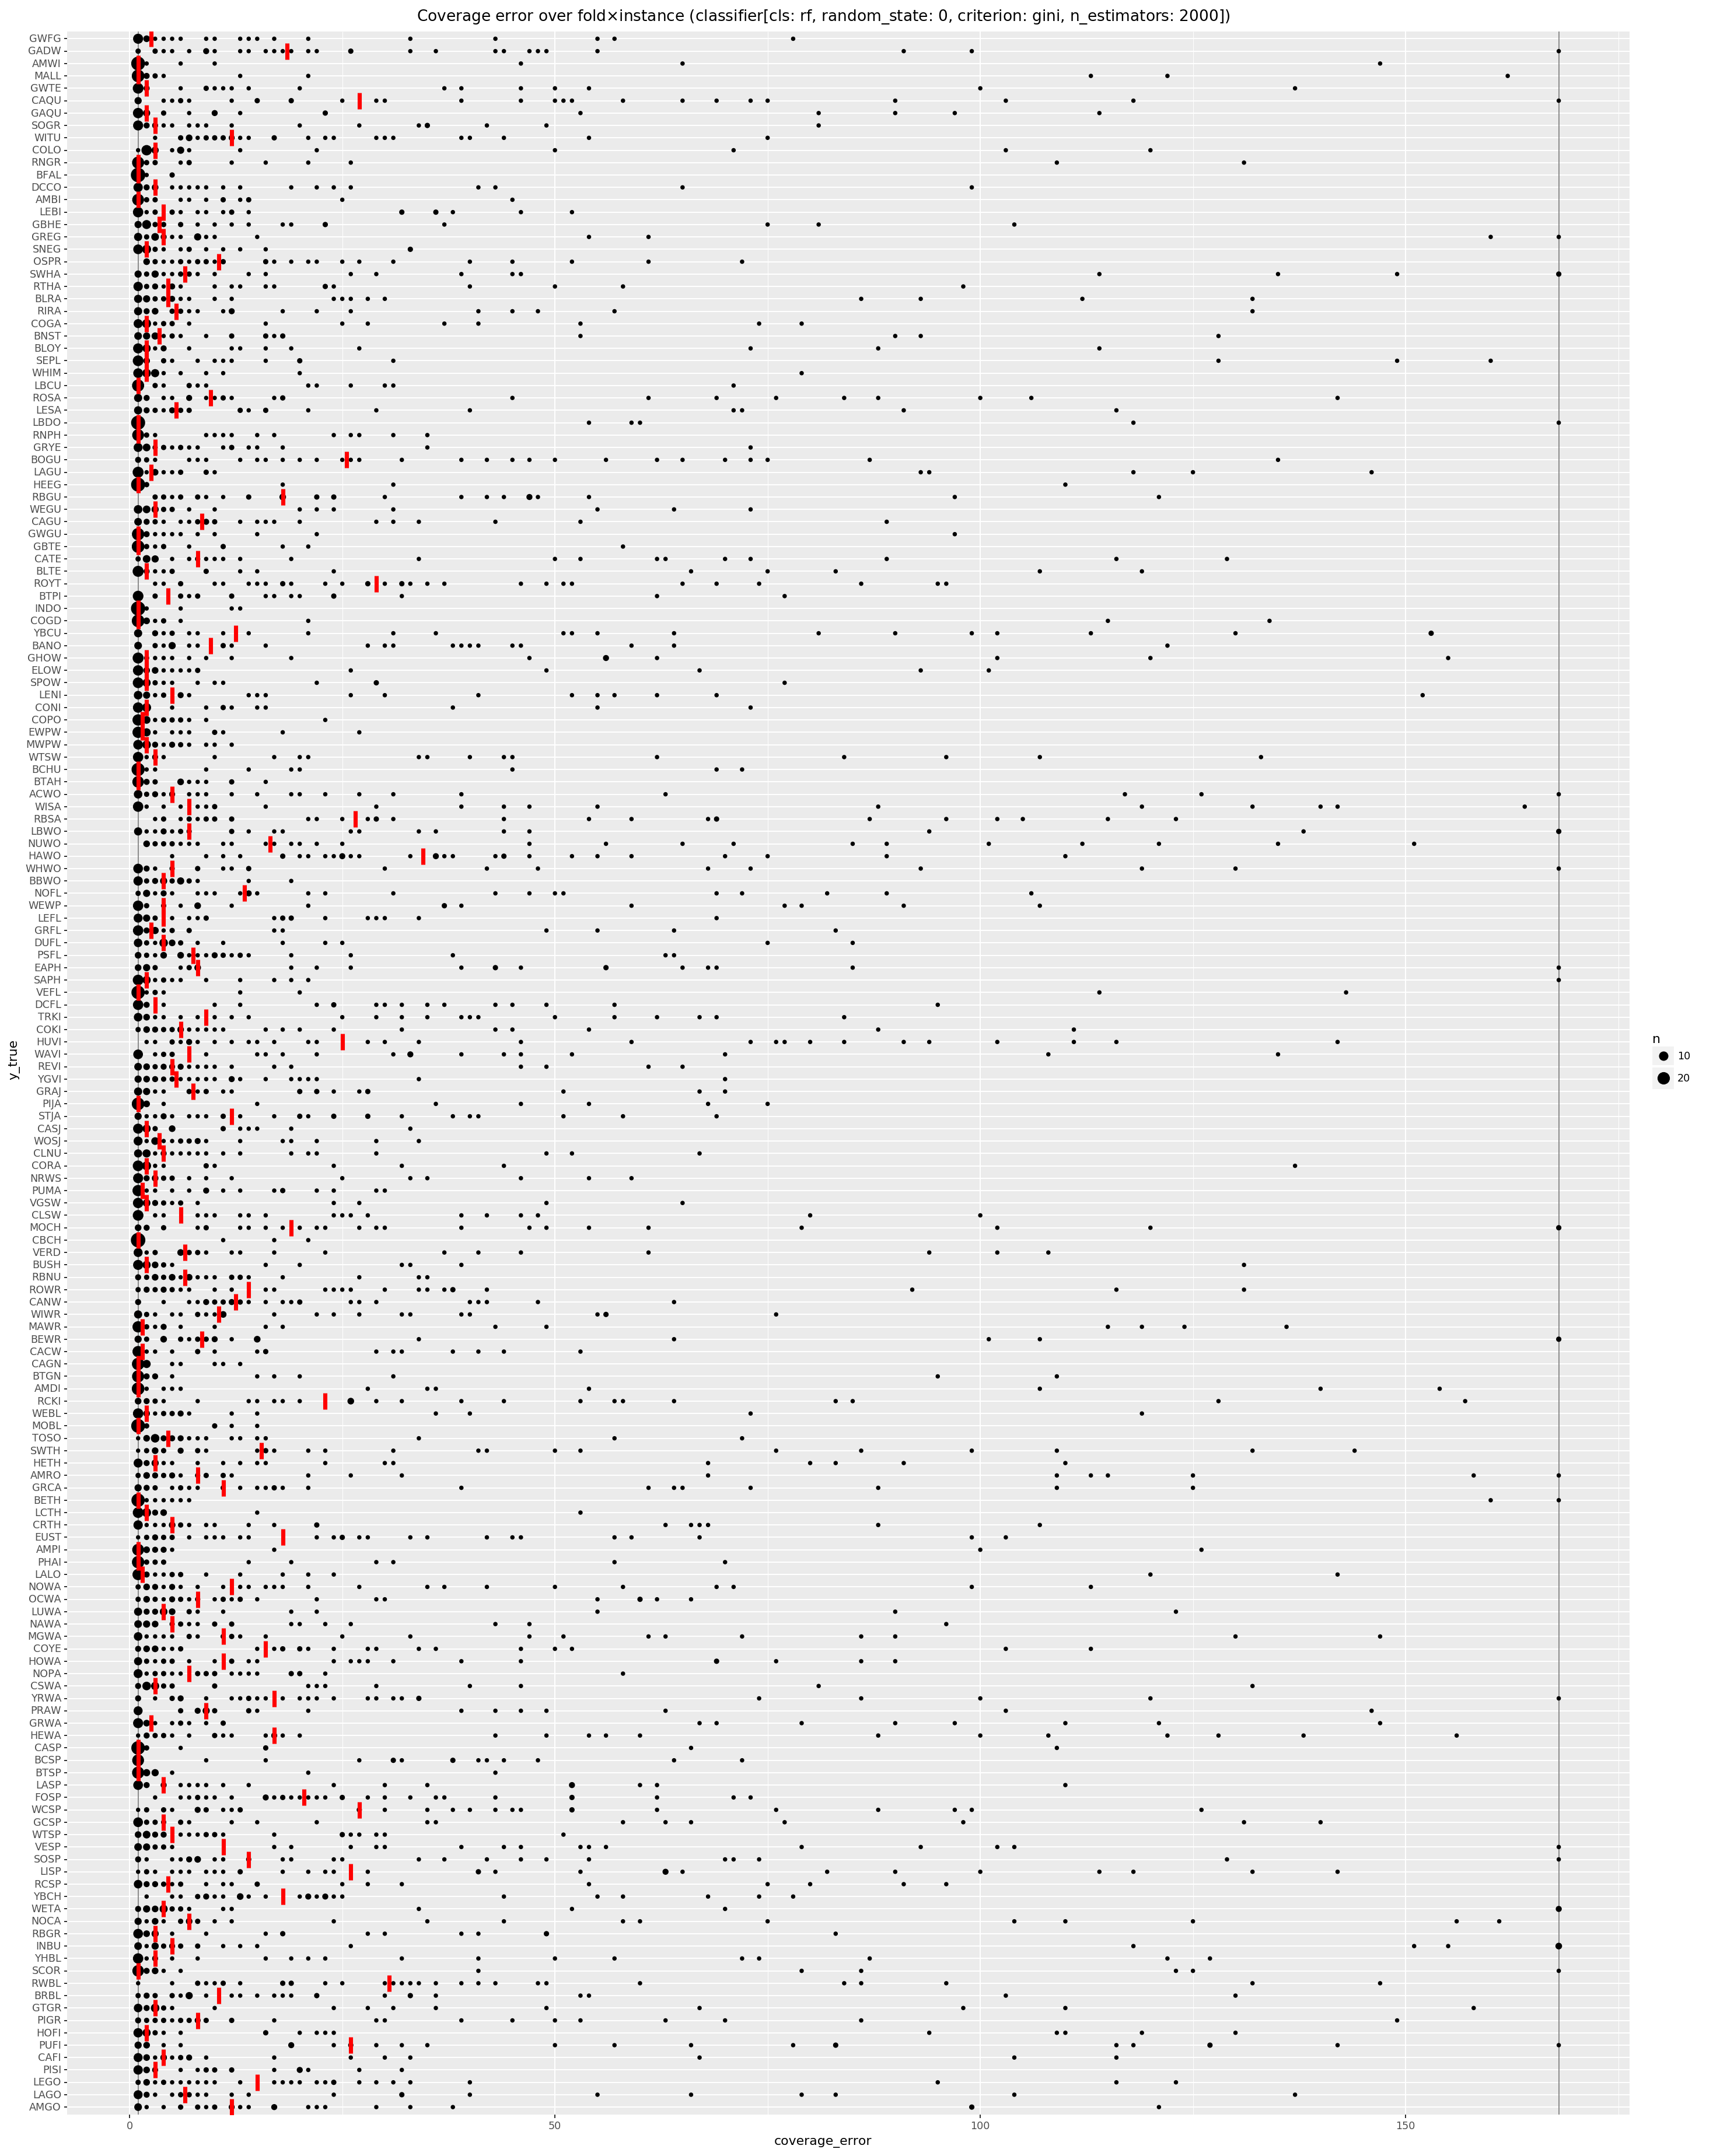

<ggplot: (-9223363254111521932)>

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance ({params})')
)

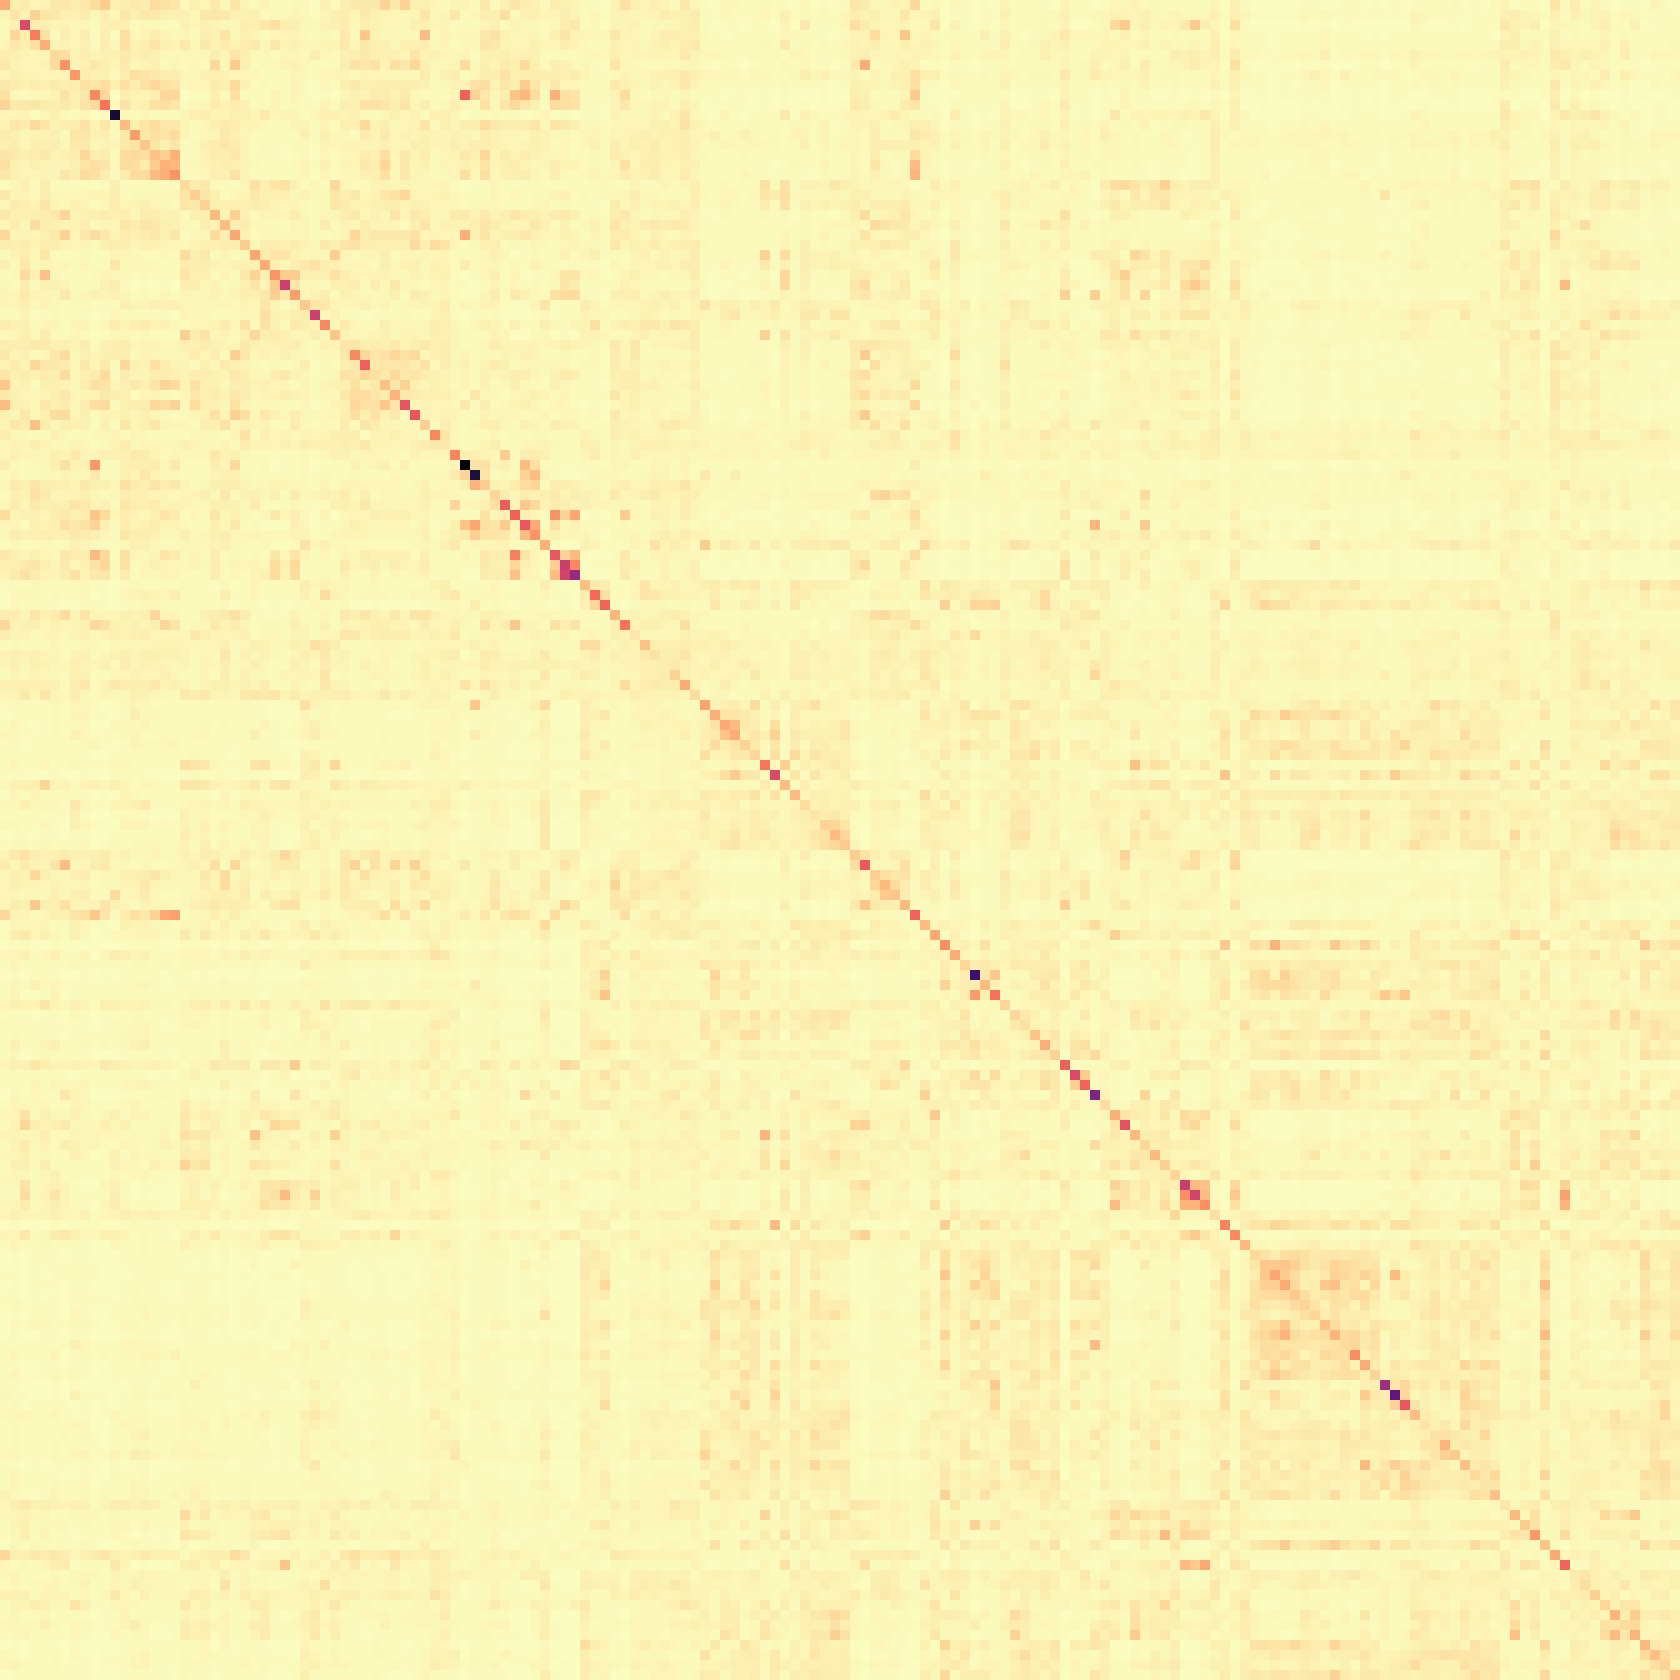

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = param_list[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("param_list:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_list)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(param_list), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

[skip]

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
    )

[skip]